In [21]:
import numpy as np
import torch
from torch import nn
from sklearn import datasets
import matplotlib.pyplot as plt
import torch.distributions as dist

w0 = 0.125
b0 = 5.
x_range = [-20, 60]

def load_dataset(n=150, n_tst=150):
    np.random.seed(43)

    def s(x):
        g = (x - x_range[0]) / (x_range[1] - x_range[0])
        return 3 * (0.25 + g**2.)

    x = (x_range[1] - x_range[0]) * np.random.rand(n) + x_range[0]
    eps = np.random.randn(n) * s(x)
    y = (w0 * x * (1. + np.sin(x)) + b0) + eps
    y = (y - y.mean()) / y.std()
    idx = np.argsort(x)
    x = x[idx]
    y = y[idx]
    return y[:, None], x[:, None]

y, x = load_dataset()
X = torch.tensor(x, dtype=torch.float)
Y = torch.tensor(y, dtype=torch.float)

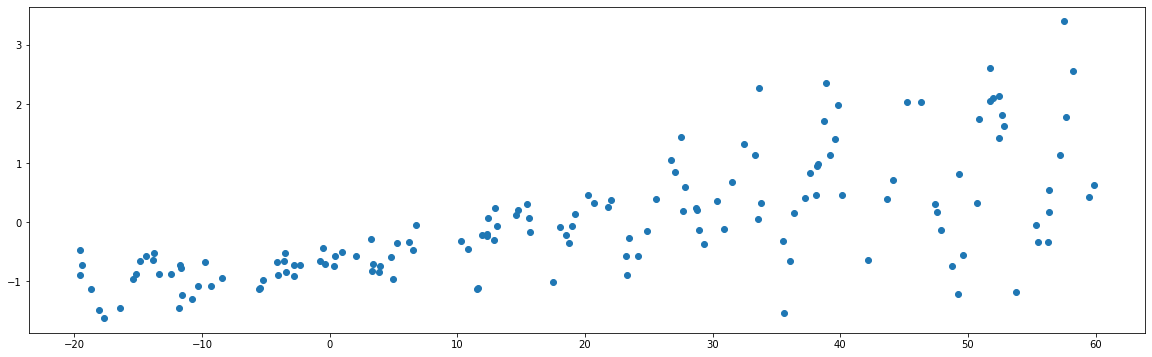

In [22]:
plt.figure(figsize=(20, 6))
plt.scatter(X,Y)

In [77]:
class LinearVariational(nn.Module):
    """
    Mean field approximation of nn.Linear
    """
    def __init__(self, in_features, out_features, parent, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.parent = parent
        self.n_batches = n_batches
        
        if getattr(parent, 'accumulated_kl_div', None) is None:
            parent.accumulated_kl_div = 0
            
        # Initialize the variational parameters.
        # 𝑄(𝑤)=N(𝜇_𝜃,𝜎2_𝜃)
        # Do some random initialization with 𝜎=0.001
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            # proxy for variance
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        log_prior = dist.Normal(0, prior_sd).log_prob(z) 
        log_p_q = dist.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).sum() / self.n_batches

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
        x = x.type(torch.double)
        w = w.type(torch.double)
        b = b.type(torch.double)
        
        z = x @ w + b
        
        self.parent.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.parent.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z

In [75]:
class KL:
    accumulated_kl_div = 0

class Model(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
        return self.layers(x)

In [67]:
epochs = 2000

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = -dist.Normal(y_pred, .1).log_prob(y).sum()
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl

m = Model(1, 20, 1, n_batches=1)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

for epoch in range(epochs):
    optim.zero_grad()
    y_pred = m(X)
    loss = det_loss(y_pred, Y, m)
    loss.backward()
    optim.step()

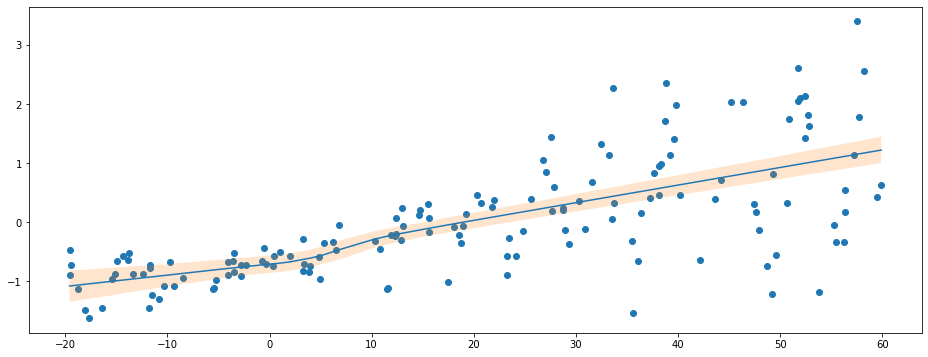

In [68]:
with torch.no_grad():
    trace = np.array([m(X).flatten().numpy() for _ in range(1000)]).T
q_25, q_95 = np.quantile(trace, [0.05, 0.95], axis=1)
plt.figure(figsize=(16, 6))
plt.plot(X, trace.mean(1))
plt.scatter(X, Y)
plt.fill_between(X.flatten(), q_25, q_95, alpha=0.2)

In [86]:
import training_utils as utils
from tqdm import tqdm
train_loader, test_data = utils.get_nanotube_data(batch_size=20)
X_test, Y_test = test_data

def plot_model_pred(model, Y_test, X_test):
    Y_sample = Y_test.detach().numpy()[:100]
    Y_pred_sample, kl = model(X_test)
    Y_pred_sample = Y_pred_sample.detach().numpy()[:100]
    plt.plot(Y_sample, "bo-", ms=8, label="target")
    plt.plot(Y_pred_sample, "ro--", ms=4, label="prediction")
    plt.legend()
    plt.show()

In [88]:
n_batches = len(train_loader)
m = Model(7, 50, 1, n_batches)
optim = torch.optim.Adam(m.parameters(), lr=0.01)

# for epoch in range(epochs):
#     optim.zero_grad()
#     y_pred = m(X)
#     loss = det_loss(y_pred, Y, m)
#     loss.backward()
#     optim.step()

def train_model(model, optimizer, train_loader, num_epochs=30):
    num_epochs = num_epochs
    pbar = tqdm(range(num_epochs))
    for i in pbar:
        for bi, (x, y) in enumerate(train_loader):
            # print(x.shape)
            # print(y.shape)
            x = x.type(torch.double)
            y = y.type(torch.double)
            y_pred= model(x)
            loss = det_loss(y_pred, y, m)
            loss.backward()
            optimizer.step()

        pbar.set_description(f"{loss}")

In [89]:
train_model(m, optim, train_loader)
Y_test = Y_test.type(torch.double)
X_test = X_test.type(torch.double)
plot_model_pred(m, Y_test, X_test)

33615.21604323682:   7%|▋         | 2/30 [00:07<01:44,  3.74s/it] 


ValueError: Expected parameter scale (Tensor of shape (50, 50)) of distribution Normal(loc: torch.Size([50, 50]), scale: torch.Size([50, 50])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[5.9604e-06, 6.1989e-06, 6.6993e+00,  ..., 8.2254e-06, 7.1536e+00,
         4.8482e+00],
        [5.8110e+00, 7.2353e+00, 1.0729e-05,  ..., 6.7949e-06, 6.7053e+00,
         7.8678e-06],
        [5.8412e-06, 6.5556e+00, 5.8412e-06,  ..., 7.0408e+00, 5.7220e-06,
         5.6076e+00],
        ...,
        [5.6028e-06, 8.3446e-06, 5.4836e-06,  ..., 1.2242e+00, 1.8655e-04,
         7.1689e+00],
        [7.1389e+00, 8.3602e-03, 5.6028e-06,  ..., 1.1921e-07, 6.6339e+00,
         6.5187e+00],
        [6.7068e+00, 7.2150e+00, 7.0174e+00,  ..., 1.6185e-01, 5.8412e-06,
         7.0902e+00]], grad_fn=<LogBackward0>)

In [43]:
X_test.dtype

torch.float64